In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ten_stocks = pd.read_csv('30min_df.csv')

In [3]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

## Ljung Box Test and Dicket Fuller Test of price

In [4]:
import statsmodels.api as sm

# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput['p-value']  # p<0.05, Stationary

results = pd.DataFrame(columns=['stock', 'ljung_p', 'dickey-fuller_p'])
for stock_name in pool:
    result = {'stock': stock_name, 'ljung_p': sm.stats.acorr_ljungbox(ten_stocks[stock_name].dropna(), lags=[12])[1][0]
             , 'dickey-fuller_p': test_stationarity(ten_stocks[stock_name].dropna())}
    results = results.append(result, ignore_index=True) 
results

,stock,ljung_p,dickey-fuller_p
0,600094.XSHG,0.0,0.336184
1,600160.XSHG,0.0,0.001549
2,600008.XSHG,0.0,0.035244
3,600903.XSHG,0.0,0.007036
4,000959.XSHE,0.0,0.353838
5,600970.XSHG,0.0,0.011225
6,002302.XSHE,0.0,0.136667
7,600823.XSHG,0.0,0.036659
8,002503.XSHE,0.0,0.486607
9,600664.XSHG,0.0,0.364086


## Price plot

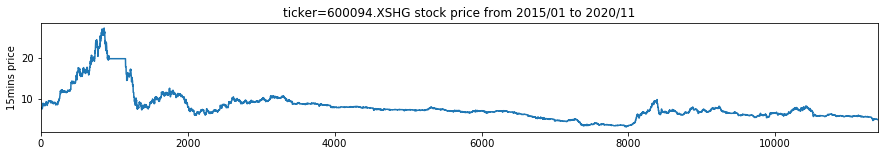

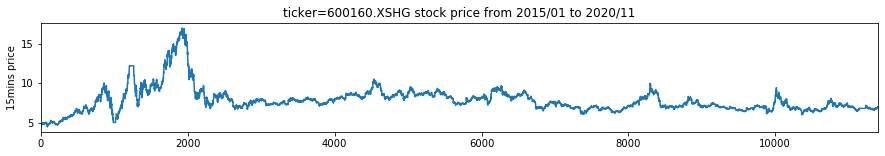

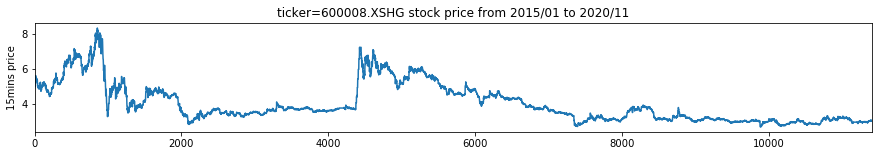

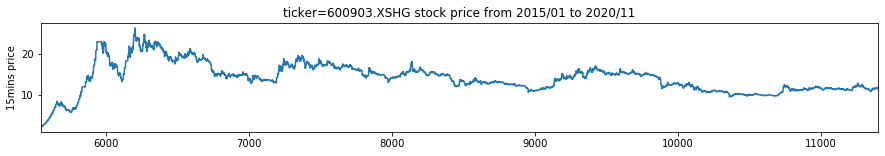

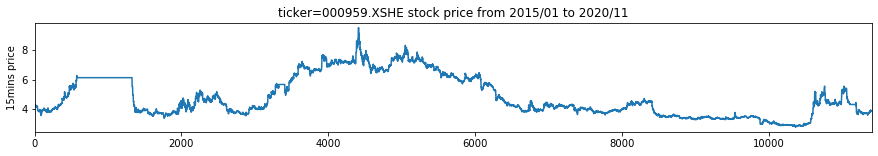

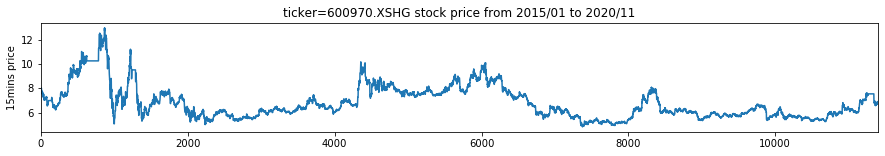

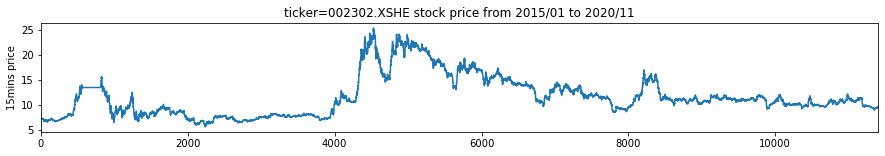

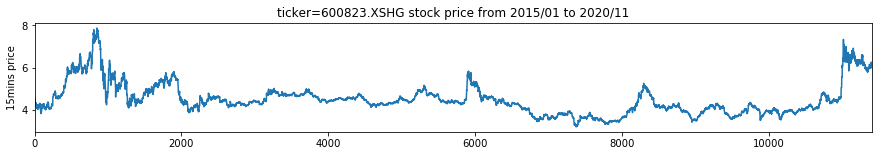

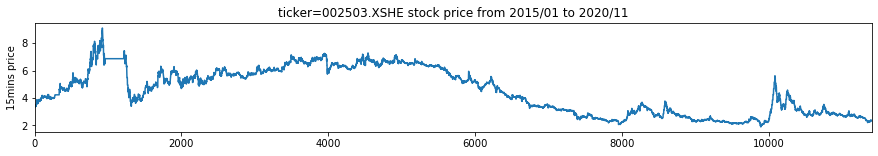

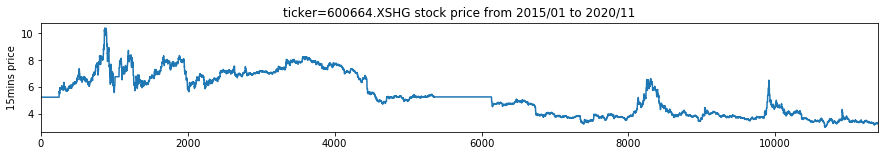

In [5]:
for stock_name in pool:
    ten_stocks[stock_name].dropna().plot(figsize=(15,2))
    plt.ylabel('15mins price')
    plt.title('ticker='+stock_name+' stock price from 2015/01 to 2020/11')
    plt.show()

## Log return plot + ACF/PACF

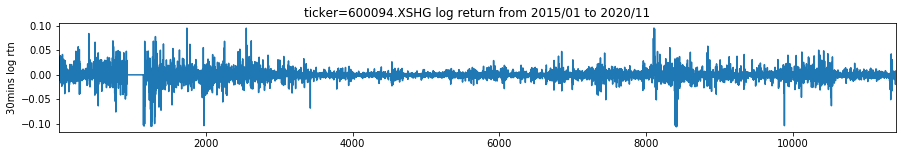

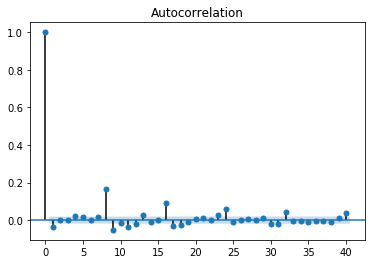

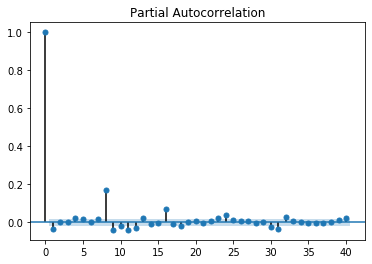

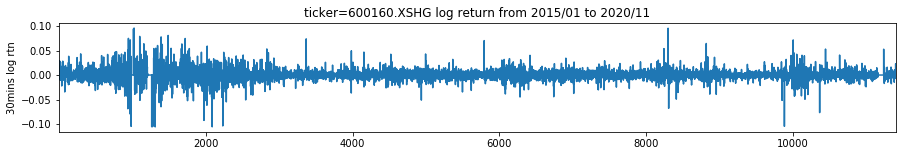

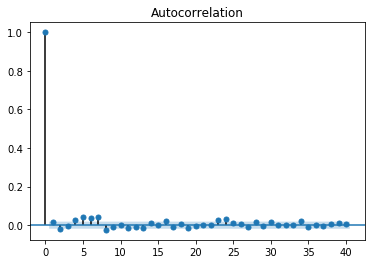

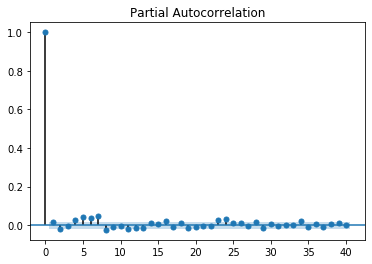

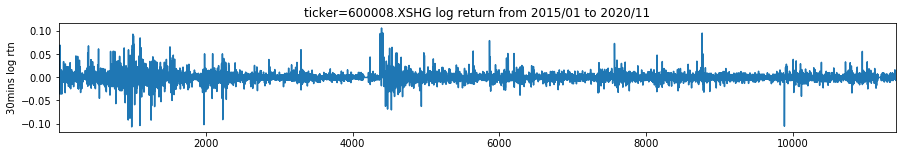

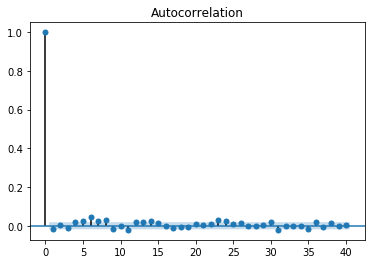

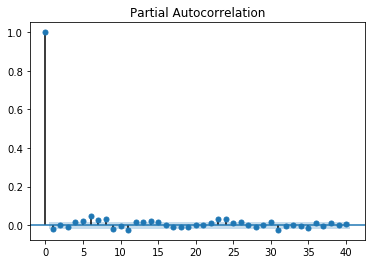

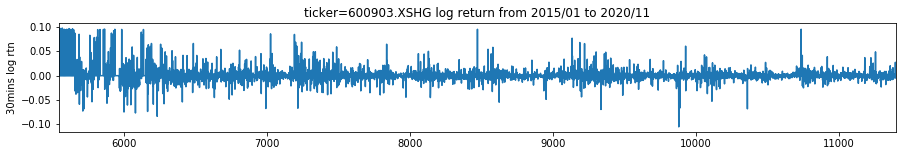

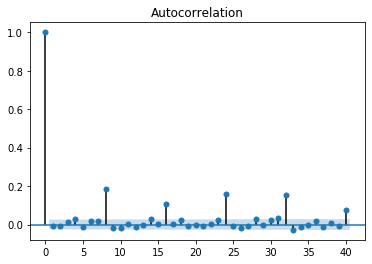

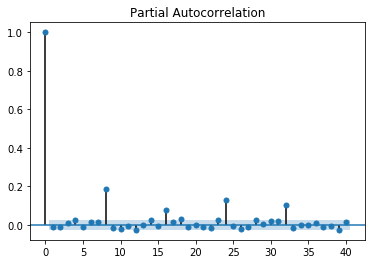

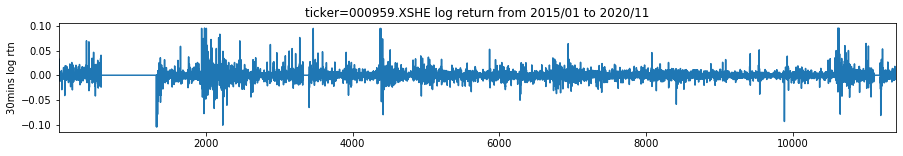

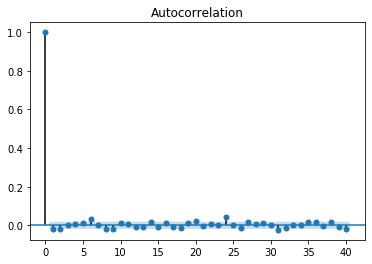

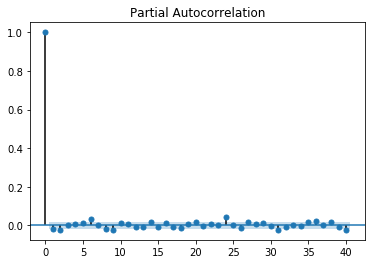

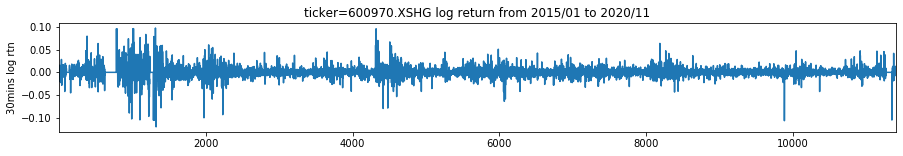

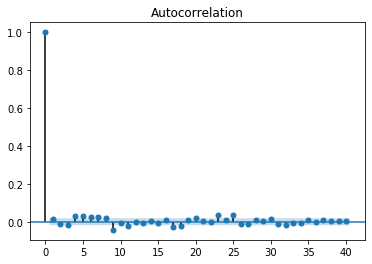

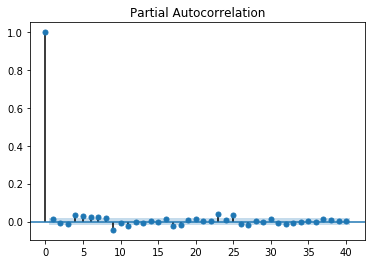

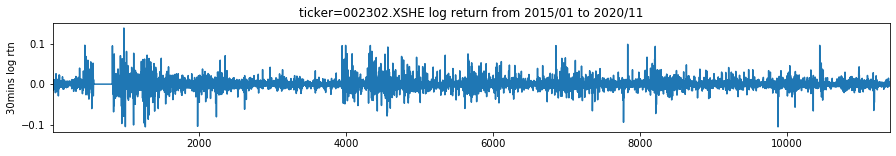

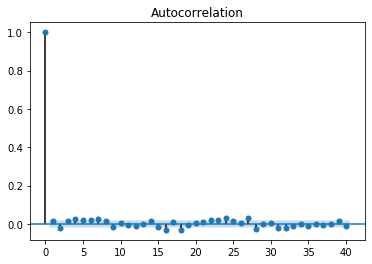

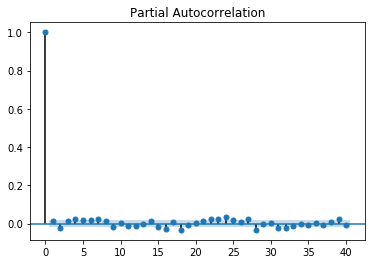

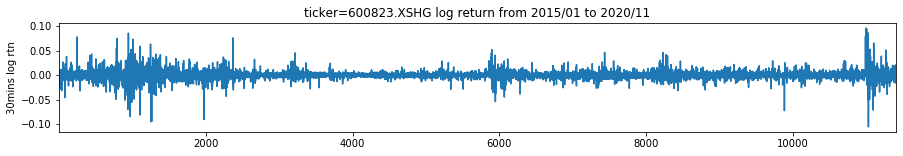

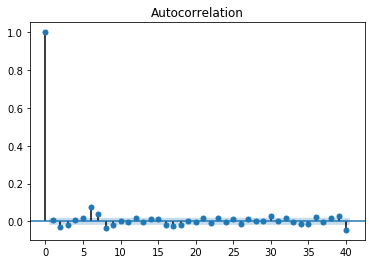

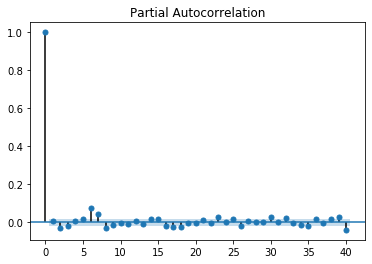

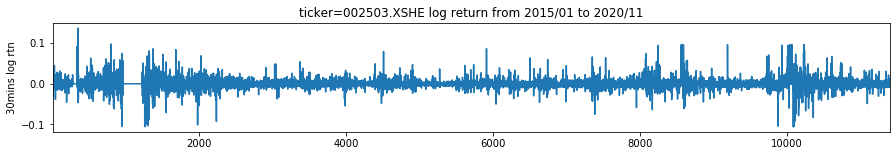

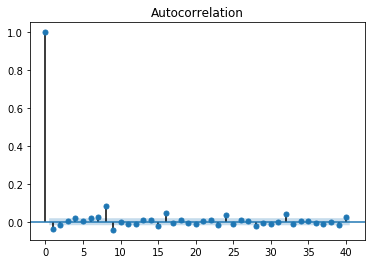

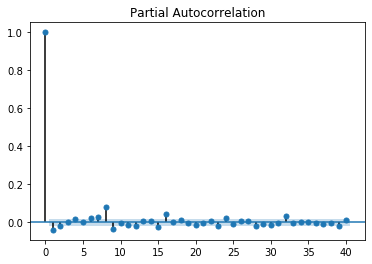

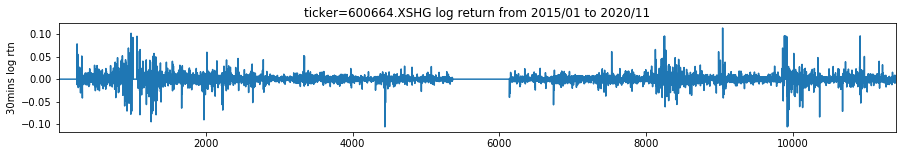

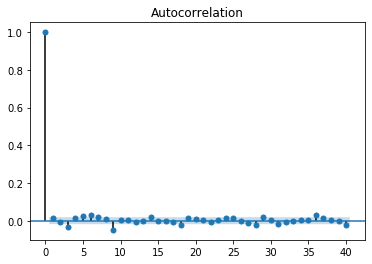

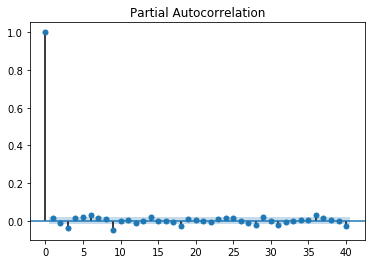

In [7]:
log_rtn_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_ten[stock_name] = log_rtn
    log_rtn.plot(figsize=(15,2))
    plt.ylabel('30mins log rtn')
    plt.title('ticker='+stock_name+' log return from 2015/01 to 2020/11')
    plt.show()
    sm.graphics.tsa.plot_acf(log_rtn, lags=40) 
    plt.show()
    sm.graphics.tsa.plot_pacf(log_rtn, lags=40)
    plt.show()

## ARMA

In [8]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(6)
q = range(6)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)

results = pd.DataFrame(columns=['stock_name', 'p', 'q', 'ljung_p', 'aic'])

def train_ARMA(param):
    global results
    p = param[0]
    q = param[1]
    print(str(param))
    for stock_name, log_rtn in log_rtn_ten.items():
        try:
            model = ARIMA(log_rtn, order=(p,0,q))

            model_fit = model.fit(disp=0)
            ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q])[1][0]
            aic = model_fit.aic
            results = results.append({'stock_name': stock_name, 'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}, ignore_index=True)
        except:
            continue



for pq in combinations:
    train_ARMA(pq)

results

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)


,stock_name,p,q,ljung_p,aic
0,600094.XSHG,0,1,3.089232e-74,-72572.819418
1,600160.XSHG,0,1,5.435954e-12,-71716.746790
2,600008.XSHG,0,1,6.256739e-09,-73311.610246
3,600903.XSHG,0,1,1.472185e-40,-34247.950965
4,000959.XSHE,0,1,5.139536e-04,-74872.333539
...,...,...,...,...,...
279,600094.XSHG,5,5,9.240171e-02,-72776.613658
280,600160.XSHG,5,5,5.581441e-01,-71791.867517
281,600903.XSHG,5,5,1.175270e-01,-34373.530031
282,600823.XSHG,5,5,8.515698e-01,-76999.864308


In [9]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,stock_name,p,q,ljung_p,aic
165,000959.XSHE,3,3,0.313446,-74890.322085
204,002302.XSHE,4,2,0.970660,-68448.600166
283,002503.XSHE,5,5,0.584620,-69136.686791
271,600008.XSHG,5,4,0.992408,-73379.093266
279,600094.XSHG,5,5,0.092402,-72776.613658
280,600160.XSHG,5,5,0.558144,-71791.867517
217,600664.XSHG,4,3,0.899675,-74570.738052
282,600823.XSHG,5,5,0.851570,-76999.864308
281,600903.XSHG,5,5,0.117527,-34373.530031
274,600970.XSHG,5,4,0.757138,-72023.406604
